In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, IterativeImputer

In [46]:
data = pd.read_excel('datasets/k2.xlsx')
data.head()

,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1,1,Transit,2016,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2018-03,2018-02-15
1,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1,1,Transit,2016,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2016-10,2016-07-28
2,BD+20 594 b,BD+20 594,1,CONFIRMED,Espinoza et al. 2016,1,1,Transit,2016,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2017-03,2018-04-26
3,EPIC 201111557.01,EPIC 201111557,1,CANDIDATE,Livingston et al. 2018,1,0,Transit,2018,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-08-02,2018-08,2018-08-02
4,EPIC 201111557.01,EPIC 201111557,0,CANDIDATE,Livingston et al. 2018,1,0,Transit,2018,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-02-15,2018-03,2018-02-15


In [47]:
data.columns.value_counts

<bound method IndexOpsMixin.value_counts of Index(['pl_name', 'hostname', 'default_flag', 'disposition', 'disp_refname',
       'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility',
       'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper',
       'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax',
       'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade',
       'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1',
       'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1',
       'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1',
       'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen',
       'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol',
       'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1',
       'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype',
       'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad',
       'st_

#### Removing the unwanted columns which include -
```
Names
Errors
System composition - they are helpful after planet discover
Units relative to jupyter
Dates
```

In [48]:
keep_cols = [
    'pl_orbper',      # Orbital period
    'pl_orbsmax',     # Semi-major axis
    'pl_rade',        # Planet radius (Earth radii)
    'pl_bmasse',      # Planet mass (Earth masses)
    'pl_orbeccen',    # Orbital eccentricity
    'pl_insol',       # Insolation flux
    'pl_eqt',         # Equilibrium temperature

    # Stellar parameters
    'st_teff',        # Stellar effective temperature
    'st_rad',         # Stellar radius
    'st_mass',        # Stellar mass
    'st_met',         # Stellar metallicity
    'st_logg',        # Stellar surface gravity

    # System observational info
    'sy_dist',        # Distance to system (pc)
    'sy_vmag',        # V-band magnitude
    'sy_kmag',        # K-band magnitude
    'sy_gaiamag',     # Gaia G-band magnitude

    # Label
    "disposition"
]

In [49]:
_data = data[keep_cols]
_data.columns.value_counts

<bound method IndexOpsMixin.value_counts of Index(['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_bmasse', 'pl_orbeccen',
       'pl_insol', 'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'st_met',
       'st_logg', 'sy_dist', 'sy_vmag', 'sy_kmag', 'sy_gaiamag',
       'disposition'],
      dtype='object')>

In [50]:
_data.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,disposition
0,41.688644,NaN,2.355454,NaN,NaN,NaN,NaN,5703.00,0.956122,0.963861,-0.06,4.38000,179.4610,10.849,9.368,10.8644,CONFIRMED
1,41.685500,0.241,2.230000,16.3000,0.0,NaN,546.0,5766.00,0.928000,0.961000,-0.15,4.50000,179.4610,10.849,9.368,10.8644,CONFIRMED
2,41.685500,NaN,2.578070,22.2481,0.0,NaN,NaN,5766.00,1.080000,1.670000,-0.15,4.50000,179.4610,10.849,9.368,10.8644,CONFIRMED
3,2.301830,NaN,1.120000,NaN,NaN,NaN,1054.0,4616.52,0.762602,0.730000,-0.03,4.53679,97.1795,11.727,9.220,11.3995,CANDIDATE
4,2.302368,NaN,1.312588,NaN,NaN,NaN,NaN,4720.00,0.710995,NaN,-0.06,4.50000,97.1795,11.727,9.220,11.3995,CANDIDATE


In [51]:
nan_counts = _data.isna().sum()
print(nan_counts)

pl_orbper        44
pl_orbsmax     3087
pl_rade         826
pl_bmasse      3543
pl_orbeccen    3480
pl_insol       3369
pl_eqt         3148
st_teff        1111
st_rad          128
st_mass        1887
st_met         2293
st_logg        1647
sy_dist         125
sy_vmag          42
sy_kmag          23
sy_gaiamag       56
disposition       0
dtype: int64


In [52]:
_data["disposition"].value_counts()

disposition
CONFIRMED         2222
CANDIDATE         1369
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64

#### Removing *CANDIDATE* and *REFUTED* as they don't give helpful info to detect exoplanet 

In [53]:
_data = _data.loc[~_data["disposition"].isin(["CANDIDATE", "REFUTED"])]

In [54]:
nan_counts = _data.isna().sum()
print(nan_counts)
print(_data.shape)

pl_orbper        24
pl_orbsmax     1730
pl_rade         554
pl_bmasse      2152
pl_orbeccen    2090
pl_insol       2032
pl_eqt         1842
st_teff         520
st_rad           91
st_mass         872
st_met         1248
st_logg         871
sy_dist          67
sy_vmag          25
sy_kmag          14
sy_gaiamag       19
disposition       0
dtype: int64
(2515, 17)


#### Removing columns with more than ~40% nan values

In [55]:
_data = _data.drop(columns=['pl_orbsmax', 'pl_bmasse', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_met'])
nan_counts = _data.isna().sum()
print(nan_counts)
print(_data.shape)

pl_orbper       24
pl_rade        554
st_teff        520
st_rad          91
st_mass        872
st_logg        871
sy_dist         67
sy_vmag         25
sy_kmag         14
sy_gaiamag      19
disposition      0
dtype: int64
(2515, 11)


array([[<Axes: title={'center': 'pl_orbper'}>,
        <Axes: title={'center': 'pl_rade'}>,
        <Axes: title={'center': 'st_teff'}>],
       [<Axes: title={'center': 'st_rad'}>,
        <Axes: title={'center': 'st_mass'}>,
        <Axes: title={'center': 'st_logg'}>],
       [<Axes: title={'center': 'sy_dist'}>,
        <Axes: title={'center': 'sy_vmag'}>,
        <Axes: title={'center': 'sy_kmag'}>],
       [<Axes: title={'center': 'sy_gaiamag'}>, <Axes: >, <Axes: >]],
      dtype=object)

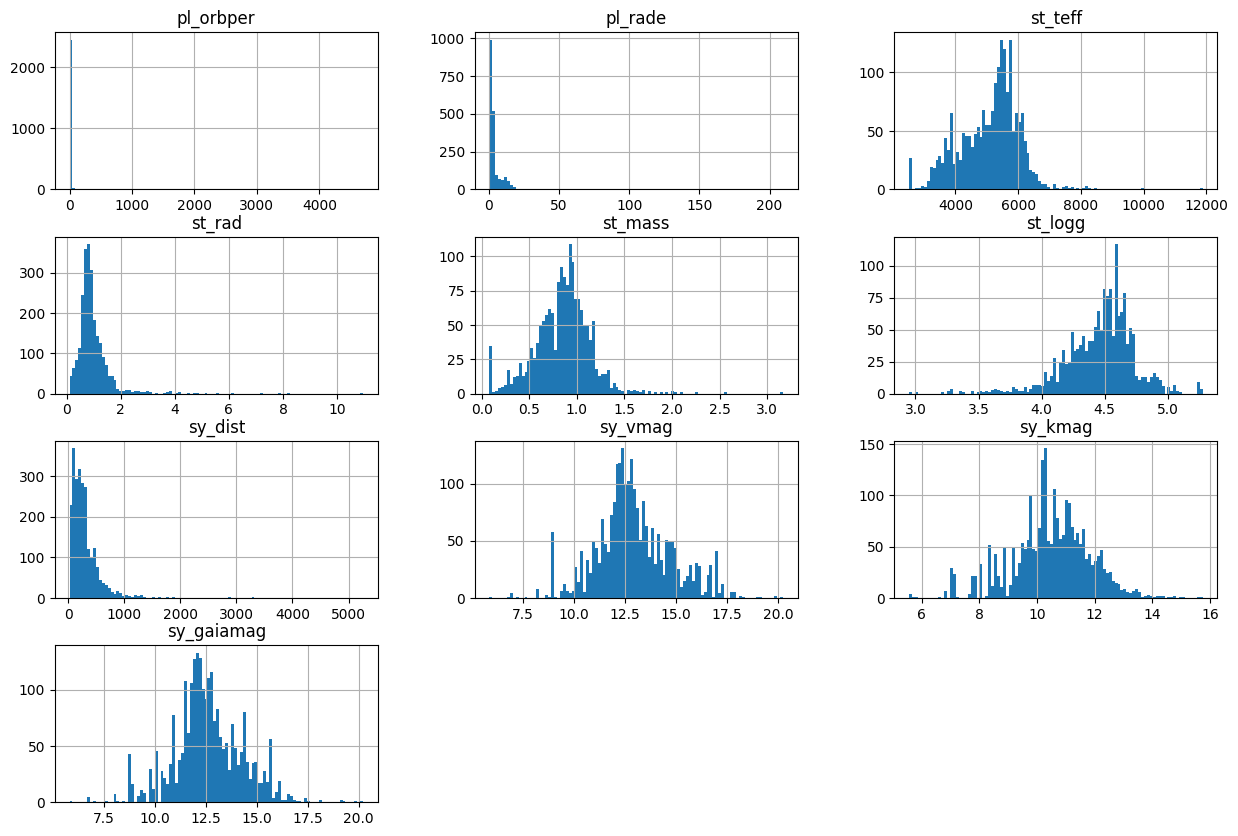

In [56]:
_data.hist(bins=100,figsize=(15,10))

In [57]:
_data.describe()

,pl_orbper,pl_rade,st_teff,st_rad,st_mass,st_logg,sy_dist,sy_vmag,sy_kmag,sy_gaiamag
count,2491.000000,1961.000000,1995.000000,2424.000000,1643.000000,1644.000000,2448.000000,2490.000000,2501.000000,2496.000000
mean,19.064546,5.117678,5091.170466,0.974824,0.853003,4.462501,308.373643,12.935777,10.483738,12.600800
std,161.828712,11.253227,945.008175,0.640488,0.294157,0.279951,337.398745,1.843494,1.359978,1.676527
min,0.179715,0.406400,2520.000000,0.110000,0.080000,2.950000,21.818200,5.840000,5.567000,5.808980
25%,3.114899,1.720000,4456.000000,0.670000,0.687363,4.314000,132.345000,11.936000,9.749000,11.712400
50%,7.050200,2.480000,5286.000000,0.856270,0.880000,4.500000,232.964000,12.717000,10.536000,12.452800
75%,13.794983,4.120000,5726.000000,1.115500,1.020000,4.630000,364.048000,13.997750,11.328000,13.663500
max,4700.000000,209.520000,11886.000000,10.960000,3.165000,5.275960,5260.000000,20.246000,15.740000,20.222300


### SPLIT

In [58]:
labels = _data['disposition'].apply(lambda x: 1 if x=="CONFIRMED" else 0)
features = _data.drop(columns=["disposition"])
X_train, X_test_val, y_train, y_test_val = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val)

#### PREPROCESS

In [59]:
def preprocess(X):
    # 1. Log transform skewed columns
    skewed_cols = ["pl_orbper", "pl_orbsmax", "pl_bmasse", "pl_insol", "pl_rade"]  
    for col in skewed_cols:
        if col in X.columns:
            X[col] = np.log1p(X[col])

    # 2. Median imputation for selected columns (excluding st_mass)
    median_cols = ["pl_orbper", "pl_orbsmax", "pl_bmasse", "pl_insol"]
    for col in median_cols:
        if col in X.columns:
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)

    # 3. Impute st_mass using IterativeImputer with st_rad and st_teff as predictors
    if "st_mass" in X.columns and "st_rad" in X.columns and "st_teff" in X.columns:
        imputer_mass = IterativeImputer(random_state=42, max_iter=10, initial_strategy="median")
        mass_features = ["st_mass", "st_rad", "st_teff"]
        X[mass_features] = imputer_mass.fit_transform(X[mass_features])

    # 4. KNN imputation for remaining numeric columns
    knn_cols = [col for col in X.columns if col not in median_cols + ["st_mass"]]
    if knn_cols:
        knn_imputer = KNNImputer(n_neighbors=5)
        X[knn_cols] = knn_imputer.fit_transform(X[knn_cols])

    # 5. Standard scaling
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), 
                           columns=X.columns, index=X.index)

    return X


In [60]:
X_train_final = preprocess(X_train)
X_test_final = preprocess(X_test)
X_val_final = preprocess(X_val)

C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


array([[<Axes: title={'center': 'pl_orbper'}>,
        <Axes: title={'center': 'pl_rade'}>,
        <Axes: title={'center': 'st_teff'}>],
       [<Axes: title={'center': 'st_rad'}>,
        <Axes: title={'center': 'st_mass'}>,
        <Axes: title={'center': 'st_logg'}>],
       [<Axes: title={'center': 'sy_dist'}>,
        <Axes: title={'center': 'sy_vmag'}>,
        <Axes: title={'center': 'sy_kmag'}>],
       [<Axes: title={'center': 'sy_gaiamag'}>, <Axes: >, <Axes: >]],
      dtype=object)

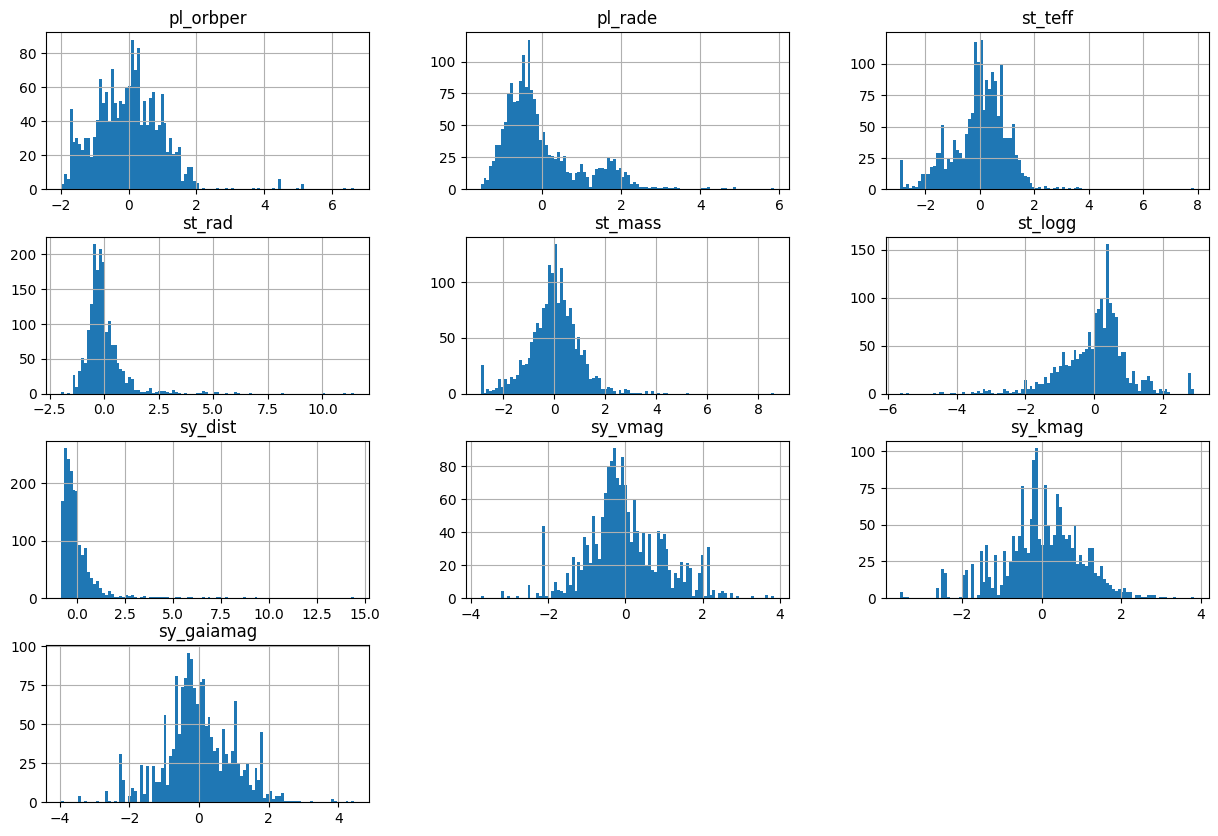

In [61]:
X_train_final.hist(bins=100, figsize=(15, 10))

array([[<Axes: title={'center': 'pl_orbper'}>,
        <Axes: title={'center': 'pl_rade'}>,
        <Axes: title={'center': 'st_teff'}>],
       [<Axes: title={'center': 'st_rad'}>,
        <Axes: title={'center': 'st_mass'}>,
        <Axes: title={'center': 'st_logg'}>],
       [<Axes: title={'center': 'sy_dist'}>,
        <Axes: title={'center': 'sy_vmag'}>,
        <Axes: title={'center': 'sy_kmag'}>],
       [<Axes: title={'center': 'sy_gaiamag'}>, <Axes: >, <Axes: >]],
      dtype=object)

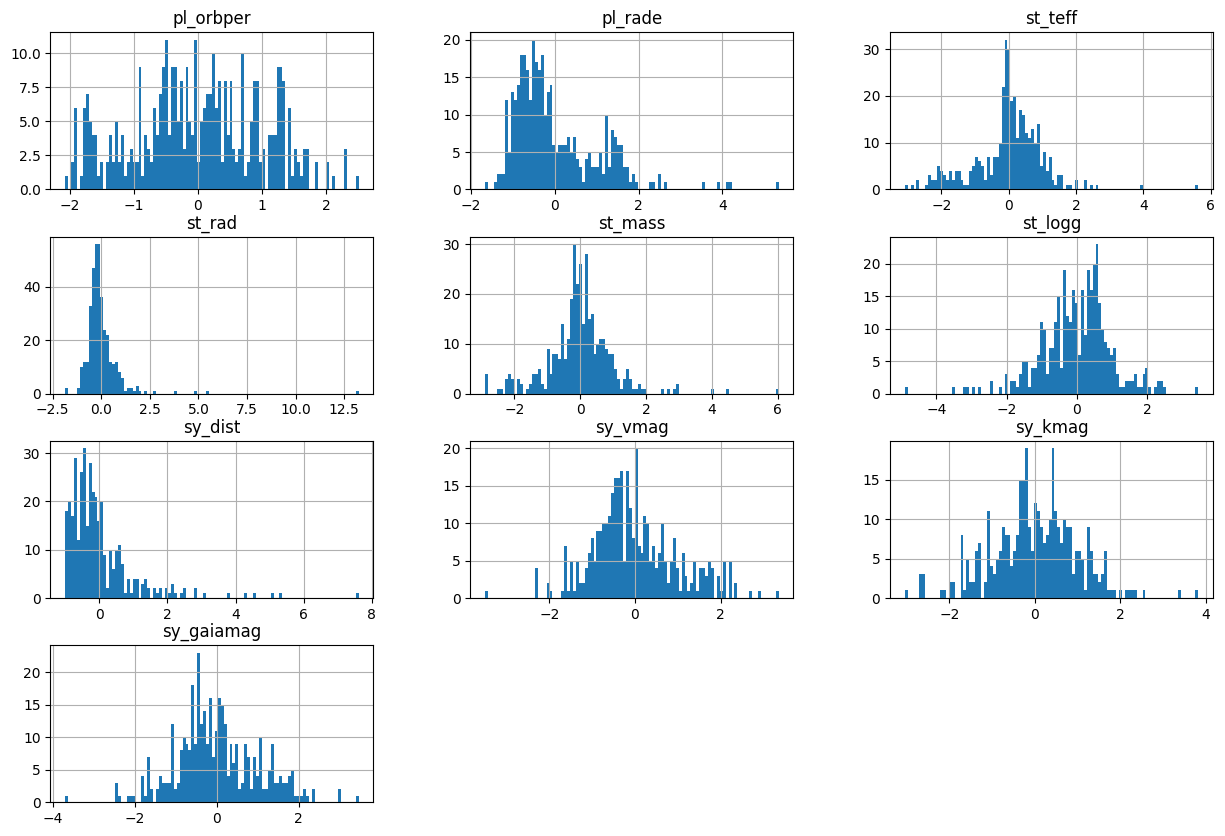

In [62]:
X_test_final.hist(bins=100, figsize=(15, 10))

array([[<Axes: title={'center': 'pl_orbper'}>,
        <Axes: title={'center': 'pl_rade'}>,
        <Axes: title={'center': 'st_teff'}>],
       [<Axes: title={'center': 'st_rad'}>,
        <Axes: title={'center': 'st_mass'}>,
        <Axes: title={'center': 'st_logg'}>],
       [<Axes: title={'center': 'sy_dist'}>,
        <Axes: title={'center': 'sy_vmag'}>,
        <Axes: title={'center': 'sy_kmag'}>],
       [<Axes: title={'center': 'sy_gaiamag'}>, <Axes: >, <Axes: >]],
      dtype=object)

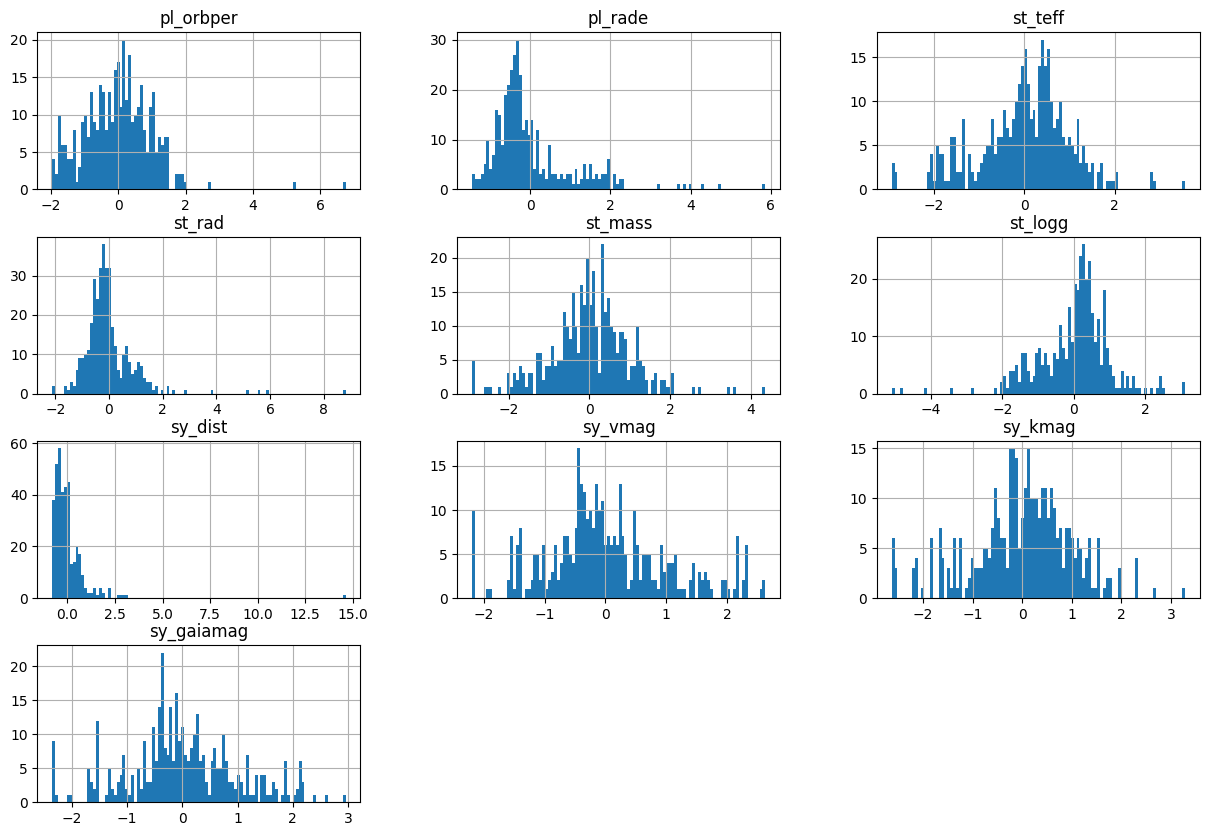

In [63]:
X_val_final.hist(bins=100, figsize=(15, 10))

In [64]:
print(X_train_final.info())
X_train_final.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1760 entries, 737 to 2215
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pl_orbper   1760 non-null   float64
 1   pl_rade     1760 non-null   float64
 2   st_teff     1760 non-null   float64
 3   st_rad      1760 non-null   float64
 4   st_mass     1760 non-null   float64
 5   st_logg     1760 non-null   float64
 6   sy_dist     1760 non-null   float64
 7   sy_vmag     1760 non-null   float64
 8   sy_kmag     1760 non-null   float64
 9   sy_gaiamag  1760 non-null   float64
dtypes: float64(10)
memory usage: 151.2 KB
None


,pl_orbper,pl_rade,st_teff,st_rad,st_mass,st_logg,sy_dist,sy_vmag,sy_kmag,sy_gaiamag
count,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03,1.760000e+03
mean,-7.973420e-17,-1.998401e-16,-4.652844e-16,-1.049665e-16,1.756171e-16,-4.440892e-17,-2.523234e-17,6.661338e-16,-8.114721e-16,3.774758e-16
std,1.000284e+00,1.000284e+00,1.000284e+00,1.000284e+00,1.000284e+00,1.000284e+00,1.000284e+00,1.000284e+00,1.000284e+00,1.000284e+00
min,-1.997346e+00,-1.547456e+00,-2.919244e+00,-1.991445e+00,-2.887675e+00,-5.636260e+00,-8.287132e-01,-3.755407e+00,-3.552522e+00,-3.968659e+00
25%,-6.964597e-01,-6.745899e-01,-4.594452e-01,-4.768123e-01,-5.349887e-01,-4.856169e-01,-5.111330e-01,-5.362146e-01,-5.250200e-01,-5.444908e-01
50%,8.620334e-03,-3.079043e-01,5.889268e-02,-1.735129e-01,2.356207e-02,1.619114e-01,-2.507529e-01,-1.190292e-01,2.601185e-02,-8.263891e-02
75%,6.449882e-01,3.908503e-01,6.393606e-01,2.255653e-01,5.490174e-01,5.269027e-01,1.595420e-01,5.854332e-01,6.171155e-01,6.278192e-01
max,6.653401e+00,5.865225e+00,7.855796e+00,1.146361e+01,8.615388e+00,2.896639e+00,1.443749e+01,3.852153e+00,3.825757e+00,4.462497e+00


#### Training

In [65]:
models = {
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4,6,8],
            "learning_rate": [0.01,0.05,0.1],
            "l2_leaf_reg": [1,3,5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100,200],
            "max_depth": [3,5,7],
            "learning_rate": [0.01,0.05,0.1],
            "subsample": [0.7,0.8,1]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            "n_estimators": [100,200],
            "max_depth": [3,5,7],
            "learning_rate": [0.01,0.05,0.1],
            "num_leaves": [31, 50, 70]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100,200],
            "max_depth": [None,5,10],
            "min_samples_split": [2,5,10]
        }
    }
}

results = {}

for name, mp in models.items():
    print(f"Training {name}...")

    # Fit GridSearchCV on train + validate using validation set as scoring
    clf = GridSearchCV(mp["model"], mp["params"], cv=3, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train_final, y_train)

    # Use validation set to select best model
    best_model = clf.best_estimator_
    y_val_pred = best_model.predict(X_val_final)

    acc_val = accuracy_score(y_val, y_val_pred)
    prec_val = precision_score(y_val, y_val_pred)
    rec_val = recall_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)

    print(f"{name} Best Params (from CV): {clf.best_params_}")
    print(f"{name} Validation Metrics -> Accuracy: {acc_val:.4f}, Precision: {prec_val:.4f}, Recall: {rec_val:.4f}, F1: {f1_val:.4f}\n")

    # Test set evaluation
    y_test_pred = best_model.predict(X_test_final)
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)

    results[name] = {
        "Best_Params": clf.best_params_,
        "Validation_Accuracy": acc_val,
        "Validation_Precision": prec_val,
        "Validation_Recall": rec_val,
        "Validation_F1": f1_val,
        "Test_Accuracy": acc_test,
        "Test_Precision": prec_test,
        "Test_Recall": rec_test,
        "Test_F1": f1_test
    }

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T
print("\nAll Model Results:\n", results_df)

Training CatBoost...
CatBoost Best Params (from CV): {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
CatBoost Validation Metrics -> Accuracy: 0.9524, Precision: 0.9620, Recall: 0.9850, F1: 0.9734

Training XGBoost...


C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:37:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params (from CV): {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
XGBoost Validation Metrics -> Accuracy: 0.9392, Precision: 0.9560, Recall: 0.9760, F1: 0.9659

Training LightGBM...
[LightGBM] [Info] Number of positive: 1555, number of negative: 205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.883523 -> initscore=2.026221
[LightGBM] [Info] Start training from score 2.026221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [66]:
results["CatBoost"]["Best_Params"]

{'depth': 4, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

#### Catboost performing best so again performing gridsearch on it

In [68]:
# Dictionary to store results
results = {}

# Models and parameters
models = {
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [150, 200, 250, 300],
            "depth": [3, 4, 5],
            "learning_rate": [0.05, 0.08, 0.1, 0.12],
            "l2_leaf_reg": [2, 3, 4],
        }
    }
}

# Make recall scorer
recall_scorer = make_scorer(recall_score)

# Loop over models
for name, mp in models.items():
    print(f"Training {name}...")

    # GridSearchCV optimizing for recall
    clf = GridSearchCV(
        mp["model"],
        mp["params"],
        cv=3,
        scoring=recall_scorer,
        n_jobs=-1
    )
    clf.fit(X_train_final, y_train)

    # Best estimator
    best_model = clf.best_estimator_

    # Validation metrics
    y_val_pred = best_model.predict(X_val_final)
    acc_val = accuracy_score(y_val, y_val_pred)
    prec_val = precision_score(y_val, y_val_pred)
    rec_val = recall_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)

    print(f"{name} Best Params (from CV optimizing Recall): {clf.best_params_}")
    print(f"{name} Validation Metrics -> Accuracy: {acc_val:.4f}, Precision: {prec_val:.4f}, Recall: {rec_val:.4f}, F1: {f1_val:.4f}\n")

    # Test set evaluation
    y_test_pred = best_model.predict(X_test_final)
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    rec_test_zero = recall_score(y_test, y_test_pred,pos_label=0)
    f1_test = f1_score(y_test, y_test_pred)

    # Store results
    results[name] = {
        "Best_Params": clf.best_params_,
        "Validation_Accuracy": acc_val,
        "Validation_Precision": prec_val,
        "Validation_Recall": rec_val,
        "Validation_F1": f1_val,
        "Test_Accuracy": acc_test,
        "Test_Precision": prec_test,
        "Test_Recall": rec_test,
        "Test_Recall_zero": rec_test_zero,
        "Test_F1": f1_test
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nAll Model Results:\n", results_df)


Training CatBoost...
CatBoost Best Params (from CV optimizing Recall): {'depth': 5, 'iterations': 250, 'l2_leaf_reg': 2, 'learning_rate': 0.12}
CatBoost Validation Metrics -> Accuracy: 0.9418, Precision: 0.9643, Recall: 0.9701, F1: 0.9672


All Model Results:
                                                 Best_Params  \
CatBoost  {'depth': 5, 'iterations': 250, 'l2_leaf_reg':...   

         Validation_Accuracy Validation_Precision Validation_Recall  \
CatBoost            0.941799             0.964286           0.97006   

         Validation_F1 Test_Accuracy Test_Precision Test_Recall  \
CatBoost      0.967164      0.920424       0.957704    0.951952   

         Test_Recall_zero   Test_F1  
CatBoost         0.681818  0.954819  
